# Roman Observatory Sample Pointing Calculations

This notebook is intended to demonstrate calculation of Roman observatory pointing angles.
Specifically, we will recreate a sample calculation equivalent to the observing scenario in OS 11

In [1]:
from roman_pointing.roman_pointing import calcRomanAngles, getL2Positions, getSunPositions
import astropy.units as u
from astropy.time import Time
from astroquery.simbad import Simbad
from astropy.coordinates import (
    SkyCoord,
    Distance,
    get_body_barycentric,
    BarycentricMeanEcliptic,
)
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Query Star Data

First, query information about the target (47 UMa) and a reference star (Zeta Pup)

In [2]:
# generate Simbad object and specify returns
simbad = Simbad()
simbad.add_votable_fields("pmra", "pmdec", "plx_value", "rvz_radvel")

In [3]:
# query for 47 Uma and then build skycoord object
res = simbad.query_object("47 Uma")
target = SkyCoord(
    res["ra"].value.data[0],
    res["dec"].value.data[0],
    unit=(res["ra"].unit, res["dec"].unit),
    frame="icrs",
    distance=Distance(parallax=res["plx_value"].value.data[0] * res["plx_value"].unit),
    pm_ra_cosdec=res["pmra"].value.data[0] * res["pmra"].unit,
    pm_dec=res["pmdec"].value.data[0] * res["pmdec"].unit,
    radial_velocity=res["rvz_radvel"].value.data[0] * res["rvz_radvel"].unit,
    equinox="J2000",
    obstime="J2000",
).transform_to(BarycentricMeanEcliptic)

# query for Zeta Pup and build second skycoord object
res = simbad.query_object("zet pup")
ref = SkyCoord(
    res["ra"].value.data[0],
    res["dec"].value.data[0],
    unit=(res["ra"].unit, res["dec"].unit),
    frame="icrs",
    distance=Distance(parallax=res["plx_value"].value.data[0] * res["plx_value"].unit),
    pm_ra_cosdec=res["pmra"].value.data[0] * res["pmra"].unit,
    pm_dec=res["pmdec"].value.data[0] * res["pmdec"].unit,
    radial_velocity=res["rvz_radvel"].value.data[0] * res["rvz_radvel"].unit,
    equinox="J2000",
    obstime="J2000",
).transform_to(BarycentricMeanEcliptic)

## Compute Discrete Pointings

Now, we can compute the pointing angles for each.  For these calculations, we are placing the observatory at L2.

In [4]:
t_str = ["2026-05-21T00:00:00.0"]
t0 = Time(t_str, format="isot", scale="utc")
ts_targ = t0 + [171.25] * u.h
ts_ref = t0 + [170.75] * u.h

sun_ang_targ, yaw_targ, pitch_targ, B_C_I_targ = calcRomanAngles(
    target, ts_targ, getL2Positions(ts_targ)
)

sun_ang_ref, yaw_ref, pitch_ref, B_C_I_targ = calcRomanAngles(
    ref, ts_ref, getL2Positions(ts_ref)
)

In [5]:
print(f"Initial target pitch: {pitch_targ[0].to(u.deg)}")
print(f"Initial reference pitch: {pitch_ref[0].to(u.deg)}")
print(fr"Initial $\Delta$pitch: {(pitch_targ[0] - pitch_ref[0]).to(u.deg)}")

Initial target pitch: -6.332905475608329 deg
Initial reference pitch: -9.283439536613182 deg
Initial $\Delta$pitch: 2.950534061004854 deg


In [6]:
# Target look vector (this is the unit vector from observatory to target in ecliptic frame components):
np.matmul(B_C_I_targ[:, :, 0].T, np.array([1,0,0],ndmin=2).T)

array([[-0.39332929],
       [ 0.3473734 ],
       [-0.85124837]])

## Compute Values Over One Year

In [7]:
# Now, let's look at the pointing values over the course of a full year
t_str = ["2027-01-01T00:00:00.0"]
t0 = Time(t_str, format="isot", scale="utc")
ts = t0 + np.arange(365)*u.d

sun_ang_targ, yaw_targ, pitch_targ, B_C_I_targ = calcRomanAngles(
    target, ts, getL2Positions(ts)
)

sun_ang_ref, yaw_ref, pitch_ref, B_C_I_targ = calcRomanAngles(
    ref, ts, getL2Positions(ts)
)

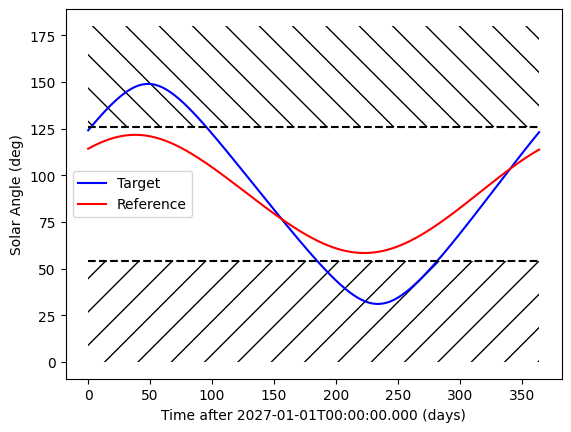

In [8]:
# plot solar angles
fig1, ax1 = plt.subplots(1, 1)
ax1.plot(range(len(ts)), sun_ang_targ.to(u.deg),'b',label="Target")
ax1.plot(range(len(ts)), sun_ang_ref.to(u.deg),'r',label="Reference")
ax1.set_xlabel(f"Time after {ts[0].value} (days)")
ax1.set_ylabel("Solar Angle (deg)")
ax1.plot([0, len(ts)-1], [54] * 2, "k--")
ax1.plot([0, len(ts)-1], [126] * 2, "k--")
ax1.fill_between(
    [0, len(ts)-1],
    [54] * 2,
    [0] * 2,
    hatch="/",
    color="none",
    edgecolor="k",
    linewidth=0,
)
ax1.fill_between(
    [0, len(ts)-1],
    [126] * 2,
    [180] * 2,
    hatch="\\",
    color="none",
    edgecolor="k",
    linewidth=0,
)
plt.legend();

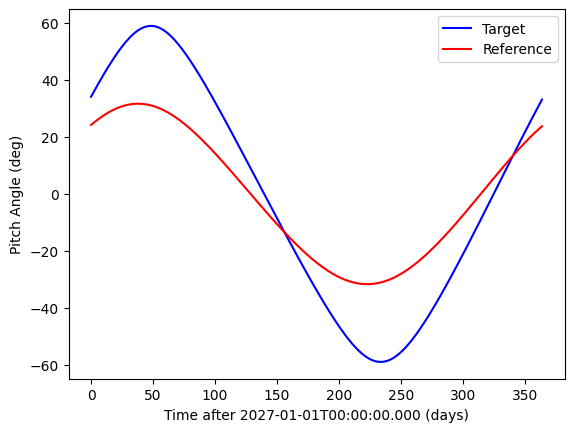

In [9]:
# plot pitch angles
fig2, ax2 = plt.subplots(1, 1)
ax2.plot(range(len(ts)), pitch_targ.to(u.deg),'b',label="Target")
ax2.plot(range(len(ts)), pitch_ref.to(u.deg),'r',label="Reference")
ax2.set_xlabel(f"Time after {ts[0].value} (days)")
ax2.set_ylabel("Pitch Angle (deg)")
plt.legend();

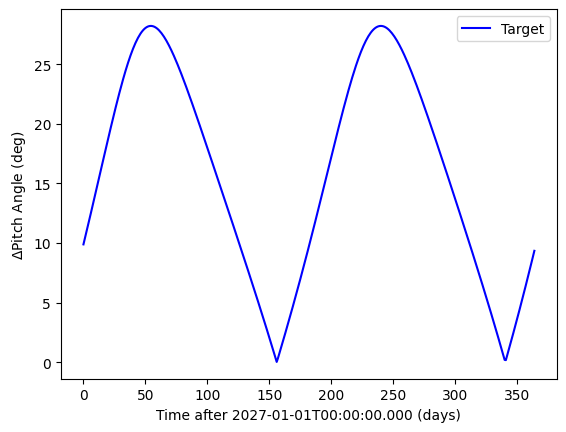

In [10]:
# plot delta pitch
fig3, ax3 = plt.subplots(1, 1)
ax3.plot(range(len(ts)), np.abs(pitch_targ - pitch_ref).to(u.deg),'b',label="Target")
ax3.set_xlabel(f"Time after {ts[0].value} (days)")
ax3.set_ylabel(r"$\Delta$Pitch Angle (deg)")
plt.legend();